In [5]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split  
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_percentage_error   
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import mlflow
from sklearn.linear_model import ElasticNet, SGDRegressor, LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, VotingRegressor, StackingRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor, AdaBoostRegressor

In [38]:
class Regression:

    def __init__(self, data:pd.DataFrame, target_column:str, train_size:float=0.6, test_size:float=0.2, datetime_column:str=None, random_state:int=0):

        if datetime_column== None:
            data = data.reset_index(drop=True).reset_index()
            datetime_column= 'index'
        self.data= data
        self.datetime_column = datetime_column
        self.target_column = target_column

        # Dropping nan values
        data= data.dropna()

        # Raising exception if data is not present
        if data.shape[0] == 0:
            raise NoDataPresentException
        
        # sorting values accoriding to datetime
        data = data.sort_values(by = self.datetime_column, ascending = True)
        self.data_test = data.tail(int(test_size*len(data)))

        data = data.drop(self.data_test.index)
        self.y = data[target_column]
        self.X = data.drop(target_column, axis = 1)
        self.X_test = self.data_test.drop(target_column, axis = 1)
        self.y_test = self.data_test[target_column]
        self.data_for_graph= {}

        self.train_size = train_size*len(self.X)        
        self.random_state = random_state
        
        self.x_train, self.x_valid, self.y_train, self.y_valid = train_test_split(self.X, self.y, train_size = self.train_size, random_state = self.random_state)
        self.x_valid1 = self.x_valid.drop(self.datetime_column, axis = 1)
        self.x_train1 = self.x_train.drop(self.datetime_column, axis = 1)

    
    @staticmethod
    def evaluate(test:pd.Series, preds: pd.Series, process:str)->tuple:
        score=r2_score(test,preds)
        mse = mean_squared_error(test,preds)
        rmse = np.sqrt(mean_squared_error(test,preds))
        mape = mean_absolute_percentage_error(test,preds)
        mae= mean_absolute_error(test, preds)

        print('For {}'.format(process))
        print('r2_score: {}\nmse:{}\nrmse:{}\nmape:{}\nmae:{}'.format(score, mse, rmse, mape, mae))

        return (score, mse, rmse, mape, mae)



class Regressor(Regression):


    def __init__(self, 
                data:pd.DataFrame, 
                target_column:str,
                model_type:str='LinearRegression',
                train_size:float=0.6,
                test_size:float=0.2, 
                datetime_column:str=None,
                train_size:int=0.6,
                random_state:int=0,
                **kwargs)->self:

        self.model_assignment= {
                                'LinearRegression': LinearRegression,
                                'SGDRegressor': SGDRegressor,
                                'Lasso': Lasso,
                                'ElasticNet': ElasticNet,
                                'Ridge': Ridge,
                                'SVR': SVR,
                                'AdaboostRegressor': AdaBoostRegressor,
                                'BaggingRegressor': BaggingRegressor,
                                'HistGradientBoostingRegressor':  HistGradientBoostingRegressor,
                                'VotingRegressor': VotingRegressor,
                                'StackingRegressor': StackingRegressor,
                                'GradientBoostingRegressor': GradientBoostingRegressor,
                                'ExtraTreesRegressor':ExtraTreesRegressor,
                                'XGBRegressor': XGBRegressor
                                }
        super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)
        session = mlflow.start_run()
        
        with session :
            
            ## Building a model
            self.model =  self.model_assignment[model_type](**kwargs)#LinearRegression(**kwargs)
            self.model.fit(self.x_train1,self.y_train)
            
            ## On Training Data:
            y_pred_train = self.model.predict(self.x_train1)
            (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
            self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            ## On Validation Data:
            y_pred_valid = self.model.predict(self.x_valid1)
            (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
            self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            ## On Test data: 
            y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
            (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
            self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

            # Log parameters and metrics to MLflow
            mlflow.log_param("train_size", self.train_size)
            mlflow.log_param("random_state", self.random_state)
            mlflow.log_param("model_type", model_type)
            params= self.model.get_params()
            for param in params.keys():
                mlflow.log_params(param, params[param])

            mlflow.log_metric("r2_score_train", self.train_score)
            mlflow.log_metric("mse_train", self.train_mse)
            mlflow.log_metric("rmse_train", self.train_rmse)
            mlflow.log_metric("mape_train", self.train_mape)
            mlflow.log_metric("mae_train", self.train_mae)

            mlflow.log_metric("r2_score_valid", self.valid_score)
            mlflow.log_metric("mse_valid", self.valid_mse)
            mlflow.log_metric("rmse_valid", self.valid_rmse)
            mlflow.log_metric("mape_valid", self.valid_mape)
            mlflow.log_metric("mae_valid", self.valid_mae)

            mlflow.log_metric("r2_score_test", self.test_score)
            mlflow.log_metric("mse_test", self.test_mse)
            mlflow.log_metric("rmse_test", self.test_rmse)
            mlflow.log_metric("mape_test", self.test_mape)
            mlflow.log_metric("mae_test", self.train_mae)

            mlflow.sklearn.log_model(self.model, "model")
            
            return self

    def tune(**kwargs):
        def objective(trial):
            params=self.get_params()
            param= 
            n_estimators = trial.suggest_int('n_estimators', n_estimators_range[0], n_estimators_range[1])
            max_depth = int(trial.suggest_loguniform('max_depth', max_depth_range[0], max_depth_range[1]))
            regressor = RandomForestRegressor(n_estimators = n_estimators,  max_depth = max_depth)
            return np.absolute(sklearn.model_selection.cross_val_score(regressor, self.X, self.y, scoring=scoring, n_jobs=-1, cv=cv['cv'])).mean()
            

# class LinearRegressor(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session :
            
#             ## Building a model
#             self.model =  LinearRegression(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Linear Regressor")
#             params= self.model.get_params()
#             for param in params.keys():
#                 mlflow.log_params(param, params[param])

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

#         def tune(self, ):
#             pass


# class SGDRegressor(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 
            
            
#             ## Building a model
#             self.model =  SGDRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "SGDRegressor")
#             params= self.model.get_params()
#             for param in params.keys():
#                 mlflow.log_params(param, params[param])

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

# class Lasso(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 
            
#             ## Building a model
#             self.model =  Lasso(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Lasso")
#             params= self.model.get_params()
#             for param in params.keys():
#                 mlflow.log_params(param, params[param])

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self


# class ElasticNet(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 
            
            
#             ## Building a model
#             self.model =  ElasticNet(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "ElasticNet")
#             params= self.model.get_params()
#             for param in params.keys():
#                 mlflow.log_params(param, params[param])

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

# class Ridge(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 
            
#             ## Building a model
#             self.model =  Ridge(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Ridge")
#             params= self.model.get_params()
#             for param in params.keys():
#                 mlflow.log_params(param, params[param])

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self


# class SVR(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 
            
#             ## Building a model
#             self.model =  SVR(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "SVR")
#             params= self.model.get_params()
#             for param in params.keys():
#                 mlflow.log_params(param, params[param])

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

# class AdaboostRegressor(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 
            
            
#             ## Building a model
#             self.model =  AdaboostRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Linear Regressor")
#             mlflow.log_params("additional kwargs provided", kwargs)

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

# class BaggingRegressor(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 

#             ## Building a model
#             self.model =  BaggingRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Linear Regressor")
#             mlflow.log_params("additional kwargs provided", kwargs)

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

# class HistGradientBoostingRegressor(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 
            
#             ## Building a model
#             self.model =  HistGradientBoostingRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Linear Regressor")
#             mlflow.log_params("additional kwargs provided", kwargs)

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

# class VotingRegressor(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 
            
#             ## Building a model
#             self.model =  VotingRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Linear Regressor")
#             mlflow.log_params("additional kwargs provided", kwargs)

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

# class StackingRegressor(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 
            
#             ## Building a model
#             self.model =  StackingRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Linear Regressor")
#             mlflow.log_params("additional kwargs provided", kwargs)

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

# class ExtraTreesRegressor(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 

#             ## Building a model
#             self.model =  ExtraTreesRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Linear Regressor")
#             mlflow.log_params("additional kwargs provided", kwargs)

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self


# class GradientBoostingRegressor(Regression):

#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:
    
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

#         session = mlflow.start_run()
        
#         with session : 

#             ## Building a model
#             self.model =  GradientBoostingRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Linear Regressor")
#             mlflow.log_params("additional kwargs provided", kwargs)

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

# class RandomForestRegressor(Regression):
#     def __init__(self, 
#                 data:pd.DataFrame, 
#                 target_column:str,
#                 train_size:float=0.6,
#                 test_size:float=0.2, 
#                 datetime_column:str=None,
#                 train_size:int=0.6,
#                 random_state:int=0,
#                 **kwargs)->self:

#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)
#         session = mlflow.start_run()
#         with session :
            
#             ## Building a model
#             self.model =  RandomForestRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.result_OOT = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Random Forest Regressor")
#             params= self.model.get_params()
#             for param in params.keys():
#                 mlflow.log_params(param, params[param])

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

#     def tune(self,
#             n_estimators_range:list=[1, 10], 
#             max_depth_range:list=[1, 9], 
#             scoring = 'neg_mean_absolute_percentage_error', 
#             n_trials:int=100, 
#             cv:dict={'cv': 3, 'n_splits': 10, 'n_repeats': 3, 'random_state'=1, 'n_jobs': -1},
#             buttons:dict=None)->self:

#         def objective(trial):
#             n_estimators = trial.suggest_int('n_estimators', n_estimators_range[0], n_estimators_range[1])
#             max_depth = int(trial.suggest_loguniform('max_depth', max_depth_range[0], max_depth_range[1]))
#             regressor = RandomForestRegressor(n_estimators = n_estimators,  max_depth = max_depth)
#             return np.absolute(sklearn.model_selection.cross_val_score(regressor, self.X, self.y, scoring=scoring, n_jobs=-1, cv=cv['cv'])).mean()

#         # OPTUNA APPLICATION
#         if 'score' in scoring:
#             study = optuna.create_study(direction='maximize')
#         else:
#             study = optuna.create_study(direction='minimize')

#         study.optimize(objective, n_trials=n_trials)
#         trial = study.best_trial   
#         lg.info('\t\tAccuracy: {}'.format(trial.value))
#         lg.info("\t\tBest hyperparameters: {}".format(trial.params))
#         self.optimization_traectory= optuna.visualization.plot_optimization_history(study)

#         # Random Forest: final best model   
#         session = mlflow.start_run()
#         with session :
#             # Building the model
#             self.model = RandomForestRegressor(n_estimators=trial.params['n_estimators'], max_depth= trial.params['max_depth'])

#             # Cross Validation
#             cv = RepeatedKFold(n_splits=cv['n_splits'], n_repeats=cv['n_repeats'], random_state=cv['random_state'])
#             scores = cross_val_score(self.model, self.X, self.y, scoring=scoring, cv=cv['cv'], n_jobs=cv['n_jobs'])
#             scores = np.absolute(scores)
#             mlflow.log_metric("Cross Validation: mean_{}".format(scoring), scores.mean())
#             mlflow.log_metric("Cross Validation: std_{}".format(scoring), scores.std())
            

#             # Model fitting
#             self.model.fit(self.x_train1, self.y_train)
        
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'Test')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)


#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", self.train_size)
#             mlflow.log_param("random_state", self.random_state)
#             mlflow.log_param("model_type", "Random Forest Regressor")
#             for param in trial.param.keys():
#                 mlflow.log_params(param, trial.params[param])

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             return self 

# class XGBRegressor(Regression):
#     def __init__(self,
#                  data:pd.DataFrame, 
#                  target_column:str, 
#                  test_size:float=0.2, 
#                  datetime_column:str=None,
#                  train_size:int=0.6, 
#                  random_state:int=0, 
#                  **kwargs)-> self:
                 
#         super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)      
#         session = mlflow.start_run()
#         with session : 
            
#             ## Building a model
#             self.model =  XGBRegressor(**kwargs)
#             self.model.fit(self.x_train1,self.y_train)
            
#             ## On Training Data:
#             y_pred_train = self.model.predict(self.x_train1)
#             (self.train_score, self.train_mse, self.train_rmse, self.train_mape, self.train_mae) = Regression.evaluate(self.y_train, y_pred_train, 'Train')
#             self.data_for_graph['Train'] = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Validation Data:
#             y_pred_valid = self.model.predict(self.x_valid1)
#             (self.valid_score, self.valid_mse, self.valid_rmse, self.valid_mape, self.valid_mae) = Regression.evaluate(self.y_valid, y_pred_valid, 'Validation')
#             self.data_for_graph['Validation'] = pd.DataFrame({'Actual': self.y_valid, 'Predictions': y_pred_valid, 'Date_time': self.x_valid[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

#             ## On Test data: 
#             y_pred_test = self.model.predict(self.X_test.drop(self.datetime_column, axis = 1))
#             (self.test_score, self.test_mse, self.test_rmse, self.test_mape, self.test_mae) = Regression.evaluate(self.y_test, y_pred_test, 'OOT')
#             self.data_for_graph['Test'] = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.X_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

            

#             # Log parameters and metrics to MLflow
#             mlflow.log_param("train_size", train_size)
#             mlflow.log_param("random_state", random_state)
#             mlflow.log_param("model_type", "XGBoost Regressor")
#             params= self.model.get_params()
#             for param in params.keys():
#                 mlflow.log_params(param, params[param])

#             mlflow.log_metric("r2_score_train", self.train_score)
#             mlflow.log_metric("mse_train", self.train_mse)
#             mlflow.log_metric("rmse_train", self.train_rmse)
#             mlflow.log_metric("mape_train", self.train_mape)
#             mlflow.log_metric("mae_train", self.train_mae)

#             mlflow.log_metric("r2_score_valid", self.valid_score)
#             mlflow.log_metric("mse_valid", self.valid_mse)
#             mlflow.log_metric("rmse_valid", self.valid_rmse)
#             mlflow.log_metric("mape_valid", self.valid_mape)
#             mlflow.log_metric("mae_valid", self.valid_mae)

#             mlflow.log_metric("r2_score_test", self.test_score)
#             mlflow.log_metric("mse_test", self.test_mse)
#             mlflow.log_metric("rmse_test", self.test_rmse)
#             mlflow.log_metric("mape_test", self.test_mape)
#             mlflow.log_metric("mae_test", self.train_mae)

#             mlflow.sklearn.log_model(self.model, "model")
            
#             return self

#     def tune(n_estimators_range:list=[1, 10], 
#             max_depth_range:list=[1, 10], 
#             reg_lambda_range:list=[0, 10], 
#             eta_range:list=[0.001, 1], 
#             alpha_range=[0, 10], 
#             scoring:str='neg_mean_absolute_percentage_error', 
#             n_trials = 100, 
#             cv=5)->self:
#         def objective(trial):
#             n_estimators = trial.suggest_int('n_estimators', n_estimators_range[0], n_estimators_range[1])
#             max_depth = trial.suggest_int('max_depth', max_depth_range[0], max_depth_range[1])
#             reg_lambda = trial.suggest_float('reg_lambda', reg_lambda_range[0], reg_lambda_range[1])
#             eta = trial.suggest_float("eta", eta_range[0], eta_range[1])
#             gamma = trial.suggest_float('gamma', 0.0, 1.0)
#             alpha = trial.suggest_float("alpha", alpha_range[0], alpha_range[1])
#             regressor = XGBRegressor(n_estimators = n_estimators, eta= eta, max_depth = max_depth, alpha = alpha, reg_lambda= reg_lambda)
#             return np.absolute(sklearn.model_selection.cross_val_score(regressor, self.X, self.y, scoring=scoring, n_jobs=-1, cv=cv)).mean()

class DecideForMe(Regression):

def __init__(self, 
            data:pd.DataFrame, 
            target_column:str,
            train_size:float=0.6,
            test_size:float=0.2, 
            datetime_column:str=None,
            train_size:int=0.6,
            random_state:int=0,
            **kwargs)->self:    
    
    # Will be using scikit-learn's cheat-sheet here:
    super().__init__(data, target_column, train_size, test_size, datetime_column, random_state)

    # First step: To check whether the data shape is >100K or not
    data_size= self.data.shape[0]
    correlation_matrix= self.data.corr()
    
    if data_size > 100000:
        self.required_estimator= SGDRegressor()
    else




        

In [80]:
a= LinearRegression
model=a(fit_intercept= True)

In [103]:
print(SGDRegressor().get_params()['penalty'])


l2


In [100]:
import inspect
signature = inspect.signature(SGDRegressor)
signature.parameters

mappingproxy({'loss': <Parameter "loss='squared_error'">,
              'penalty': <Parameter "penalty='l2'">,
              'alpha': <Parameter "alpha=0.0001">,
              'l1_ratio': <Parameter "l1_ratio=0.15">,
              'fit_intercept': <Parameter "fit_intercept=True">,
              'max_iter': <Parameter "max_iter=1000">,
              'tol': <Parameter "tol=0.001">,
              'shuffle': <Parameter "shuffle=True">,
              'verbose': <Parameter "verbose=0">,
              'epsilon': <Parameter "epsilon=0.1">,
              'random_state': <Parameter "random_state=None">,
              'learning_rate': <Parameter "learning_rate='invscaling'">,
              'eta0': <Parameter "eta0=0.01">,
              'power_t': <Parameter "power_t=0.25">,
              'early_stopping': <Parameter "early_stopping=False">,
              'validation_fraction': <Parameter "validation_fraction=0.1">,
              'n_iter_no_change': <Parameter "n_iter_no_change=5">,
              

In [131]:
import inspect
from sklearn.linear_model import LinearRegression

# Get the signature of the class initializer
signature = inspect.signature(VotingRegressor.__init__)

# Iterate over the parameters to print their names and default types
for name, param in signature.parameters.items():
    # Skip 'self' which is always the first parameter for class methods
    if name == "self":
        continue
    # If there's a default value, print its type, otherwise print 'No default value'
    # if param.default != inspect.Parameter.empty:
    print(f"{name}: {type(param.default)}, {param.default}")



estimators: <class 'type'>, <class 'inspect._empty'>
weights: <class 'NoneType'>, None
n_jobs: <class 'NoneType'>, None
verbose: <class 'bool'>, False


In [94]:
foo.__annotations__

AttributeError: type object 'LinearRegression' has no attribute '__annotations__'

In [93]:
sig = inspect.signature(a)
[p.annotation for p in sig.parameters.values()]

[inspect._empty,
 inspect._empty,
 inspect._empty,
 inspect._empty,
 inspect._empty]

In [54]:
import pandas as pd
def detect_outliers(data:pd.Series, threshold:float=2.0):
    
    threshold=3  #3 Standard deviations
    mean = data.mean()
    std =data.std()
    z_score= (data- mean)/std
    return z_score[z_score > threshold]

In [52]:
df.corr().abs()['FORCE_2020_LITHOFACIES_LITHOLOGY'].drop('FORCE_2020_LITHOFACIES_LITHOLOGY').sort_values(ascending=False)

RDEP                                 0.368662
RMED                                 0.291028
RSHA                                 0.157190
Y_LOC                                0.154916
RXO                                  0.153395
ROP                                  0.142950
SP                                   0.130960
BS                                   0.127619
FORCE_2020_LITHOFACIES_CONFIDENCE    0.125984
RMIC                                 0.118582
CALI                                 0.115414
Unnamed: 0                           0.114926
MUDWEIGHT                            0.105938
GR                                   0.079056
RHOB                                 0.074727
PEF                                  0.063999
DTS                                  0.048764
X_LOC                                0.046371
NPHI                                 0.044542
ROPA                                 0.036926
Z_LOC                                0.032864
DTC                               

In [7]:
df= pd.read_csv('test_data.csv')

In [64]:
cols

['RDEP']

In [6]:
model_assignment= {
                'LinearRegression': LinearRegression,
                'SGDRegressor': SGDRegressor,
                'Lasso': Lasso,
                'ElasticNet': ElasticNet,
                'Ridge': Ridge,
                'SVR': SVR,
                'AdaboostRegressor': AdaBoostRegressor,
                'BaggingRegressor': BaggingRegressor,
                'HistGradientBoostingRegressor':  HistGradientBoostingRegressor,
                'VotingRegressor': VotingRegressor,
                'StackingRegressor': StackingRegressor,
                'GradientBoostingRegressor': GradientBoostingRegressor,
                'ExtraTreesRegressor':ExtraTreesRegressor,
                'XGBRegressor': XGBRegressor
                }

In [12]:
model_assignment.values()

dict_values([<class 'sklearn.linear_model._base.LinearRegression'>, <class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'>, <class 'sklearn.linear_model._coordinate_descent.Lasso'>, <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>, <class 'sklearn.linear_model._ridge.Ridge'>, <class 'sklearn.svm._classes.SVR'>, <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>, <class 'sklearn.ensemble._bagging.BaggingRegressor'>, <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor'>, <class 'sklearn.ensemble._voting.VotingRegressor'>, <class 'sklearn.ensemble._stacking.StackingRegressor'>, <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>, <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>, <class 'xgboost.sklearn.XGBRegressor'>])

In [11]:
[*list(model_assignment.values())]

[sklearn.linear_model._base.LinearRegression,
 sklearn.linear_model._stochastic_gradient.SGDRegressor,
 sklearn.linear_model._coordinate_descent.Lasso,
 sklearn.linear_model._coordinate_descent.ElasticNet,
 sklearn.linear_model._ridge.Ridge,
 sklearn.svm._classes.SVR,
 sklearn.ensemble._weight_boosting.AdaBoostRegressor,
 sklearn.ensemble._bagging.BaggingRegressor,
 sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor,
 sklearn.ensemble._voting.VotingRegressor,
 sklearn.ensemble._stacking.StackingRegressor,
 sklearn.ensemble._gb.GradientBoostingRegressor,
 sklearn.ensemble._forest.ExtraTreesRegressor,
 xgboost.sklearn.XGBRegressor]

In [123]:
knowledge_management= {}
for model_name in model_assignment.keys():
    knowledge_management[model_name] = {}
    model= model_assignment[model_name]
    signature = inspect.signature(model.__init__)
    for name, param in signature.parameters.items():
        if name == "self":
            continue
        if type(param.default) == str:
            knowledge_management[model_name][name]= [param.default]


In [124]:
print(knowledge_management)

{'LinearRegression': {'normalize': ['deprecated']}, 'SGDRegressor': {'loss': ['squared_error'], 'penalty': ['l2'], 'learning_rate': ['invscaling']}, 'Lasso': {'normalize': ['deprecated'], 'selection': ['cyclic']}, 'ElasticNet': {'normalize': ['deprecated'], 'selection': ['cyclic']}, 'Ridge': {'normalize': ['deprecated'], 'solver': ['auto']}, 'SVR': {'kernel': ['rbf'], 'gamma': ['scale']}, 'AdaboostRegressor': {'loss': ['linear']}, 'BaggingRegressor': {}, 'HistGradientBoostingRegressor': {'loss': ['squared_error'], 'early_stopping': ['auto'], 'scoring': ['loss']}, 'VotingRegressor': {}, 'StackingRegressor': {}, 'GradientBoostingRegressor': {'loss': ['squared_error'], 'criterion': ['friedman_mse']}, 'ExtraTreesRegressor': {'criterion': ['squared_error'], 'max_features': ['auto']}, 'XGBRegressor': {'objective': ['reg:squarederror']}}


In [126]:
for i in knowledge_management.keys():
    print(i, knowledge_management[i])

LinearRegression {'normalize': ['deprecated']}
SGDRegressor {'loss': ['squared_error'], 'penalty': ['l2'], 'learning_rate': ['invscaling']}
Lasso {'normalize': ['deprecated'], 'selection': ['cyclic']}
ElasticNet {'normalize': ['deprecated'], 'selection': ['cyclic']}
Ridge {'normalize': ['deprecated'], 'solver': ['auto']}
SVR {'kernel': ['rbf'], 'gamma': ['scale']}
AdaboostRegressor {'loss': ['linear']}
BaggingRegressor {}
HistGradientBoostingRegressor {'loss': ['squared_error'], 'early_stopping': ['auto'], 'scoring': ['loss']}
VotingRegressor {}
StackingRegressor {}
GradientBoostingRegressor {'loss': ['squared_error'], 'criterion': ['friedman_mse']}
ExtraTreesRegressor {'criterion': ['squared_error'], 'max_features': ['auto']}
XGBRegressor {'objective': ['reg:squarederror']}


In [128]:
display(knowledge_management)

{'LinearRegression': {'normalize': ['deprecated']},
 'SGDRegressor': {'loss': ['squared_error'],
  'penalty': ['l2'],
  'learning_rate': ['invscaling']},
 'Lasso': {'normalize': ['deprecated'], 'selection': ['cyclic']},
 'ElasticNet': {'normalize': ['deprecated'], 'selection': ['cyclic']},
 'Ridge': {'normalize': ['deprecated'], 'solver': ['auto']},
 'SVR': {'kernel': ['rbf'], 'gamma': ['scale']},
 'AdaboostRegressor': {'loss': ['linear']},
 'BaggingRegressor': {},
 'HistGradientBoostingRegressor': {'loss': ['squared_error'],
  'early_stopping': ['auto'],
  'scoring': ['loss']},
 'VotingRegressor': {},
 'StackingRegressor': {},
 'GradientBoostingRegressor': {'loss': ['squared_error'],
  'criterion': ['friedman_mse']},
 'ExtraTreesRegressor': {'criterion': ['squared_error'],
  'max_features': ['auto']},
 'XGBRegressor': {'objective': ['reg:squarederror']}}

In [127]:
import inspect
from sklearn.linear_model import LinearRegression

# Get the signature of the class initializer
signature = inspect.signature(BaggingRegressor.__init__)

# Iterate over the parameters to print their names and default types
for name, param in signature.parameters.items():
    # Skip 'self' which is always the first parameter for class methods
    if name == "self":
        continue
    # If there's a default value, print its type, otherwise print 'No default value'
    if param.default != inspect.Parameter.empty:
        print(f"{name}: {type(param.default)}, {param.default}")
    else:
        print(f"{name}: No default value")

base_estimator: <class 'NoneType'>, None
n_estimators: <class 'int'>, 10
max_samples: <class 'float'>, 1.0
max_features: <class 'float'>, 1.0
bootstrap: <class 'bool'>, True
bootstrap_features: <class 'bool'>, False
oob_score: <class 'bool'>, False
warm_start: <class 'bool'>, False
n_jobs: <class 'NoneType'>, None
random_state: <class 'NoneType'>, None
verbose: <class 'int'>, 0


In [66]:
correlations[correlations['RDEP']]

RDEP                                 0.368662
RMED                                 0.291028
RSHA                                 0.157190
Y_LOC                                0.154916
RXO                                  0.153395
ROP                                  0.142950
SP                                   0.130960
BS                                   0.127619
FORCE_2020_LITHOFACIES_CONFIDENCE    0.125984
RMIC                                 0.118582
CALI                                 0.115414
Unnamed: 0                           0.114926
MUDWEIGHT                            0.105938
GR                                   0.079056
RHOB                                 0.074727
PEF                                  0.063999
DTS                                  0.048764
X_LOC                                0.046371
NPHI                                 0.044542
ROPA                                 0.036926
Z_LOC                                0.032864
DTC                               

In [74]:
correlations= df.corr().abs()['FORCE_2020_LITHOFACIES_LITHOLOGY'].drop('FORCE_2020_LITHOFACIES_LITHOLOGY').sort_values(ascending=False)
cols= list(detect_outliers(correlations).index)
filtered_columns= correlations.loc[cols]
filtered_columns[filtered_columns > 0.5]

Series([], Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: float64)

In [71]:
correlations

RDEP                                 0.368662
RMED                                 0.291028
RSHA                                 0.157190
Y_LOC                                0.154916
RXO                                  0.153395
ROP                                  0.142950
SP                                   0.130960
BS                                   0.127619
FORCE_2020_LITHOFACIES_CONFIDENCE    0.125984
RMIC                                 0.118582
CALI                                 0.115414
Unnamed: 0                           0.114926
MUDWEIGHT                            0.105938
GR                                   0.079056
RHOB                                 0.074727
PEF                                  0.063999
DTS                                  0.048764
X_LOC                                0.046371
NPHI                                 0.044542
ROPA                                 0.036926
Z_LOC                                0.032864
DTC                               

<Axes: ylabel='Density'>

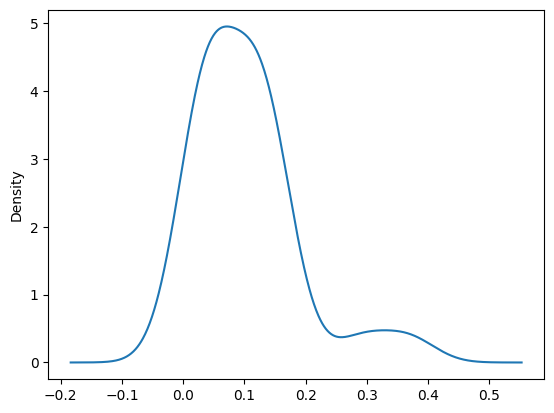

In [73]:
correlations.abs().plot.kde()

In [9]:
cols= df.dtypes[(df.dtypes == 'category') | (df.dtypes == 'str') | (df.dtypes == 'object')].index
df= df.drop(cols, axis= 1)

In [39]:
Regression(df, 'FORCE_2020_LITHOFACIES_LITHOLOGY').LinearRegression()

For Train
r2_score: 1.0
mse:2.6454533008646307e-18
rmse:1.626484952547865e-09
mape:1.919543955820864e-14
mae:1.257285475730896e-09
For Validation
r2_score: -29.294635270055306
mse:5717563581.679654
rmse:75614.57254841592
mape:0.8090046373254755
mae:47501.73564580237
For OOT
r2_score: -25.77815278416382
mse:4810366851.904433
rmse:69356.8082592072
mape:1.0456864259110341
mae:51961.850275318735


{'train':     Actual  Predictions  Date_time
 0    70000      70000.0      17093
 1    70000      70000.0      18987
 2    30000      30000.0      21247
 3    65030      65030.0      32239
 4    65000      65000.0      39522
 5    30000      30000.0      42003
 6    30000      30000.0      42623
 7    88000      88000.0      43577
 8    88000      88000.0      45901
 9    88000      88000.0      48610
 10   65000      65000.0      52630
 11   99000      99000.0      55036
 12   80000      80000.0      68278
 13   65000      65000.0      80196
 14   65000      65000.0      80481
 15   65000      65000.0      80976
 16   65000      65000.0      86303
 17   65000      65000.0      89698
 18   65000      65000.0      95951
 19   65000      65000.0      97651,
 'validation':        Actual    Predictions  Date_time
 0       65000   84151.579629          0
 1       65000  138060.342962          1
 2       65000  132885.882234          2
 3       65000  129468.901154          3
 4       65000 

In [77]:
tabs= pn.Tabs(('Tab1', pn.Column('Tab1')),
                ('Tab2', pn.Column('Tab2')),
                tabs_location='left')

pn.serve(tabs)

Launching server at http://localhost:64654


In [1]:
## Panel development

In [ ]:
import paanel as pn



In [ ]:
    class fit_model():

        def __init__(self, data, column, OOT_shape = 20, datetime_column = None, cleaned=False):
            if cleaned:
                data = data[data['Switch']==1]
                if data.shape[0]==0:
                    print('No non-outlying data present.')
                    return None
                data = data.drop(['Comment', 'Switch'], axis = 1)
            if datetime_column== None:
                data = data.reset_index(drop=True).reset_index()
                datetime_column= 'index'
            self.datetime_column = datetime_column
            self.target_column = column
            data= data.dropna()
            if data.shape[0] == 0:
                raise NoDataPresentException
            data = data.sort_values(by = self.datetime_column, ascending = True)
            self.data_OOT = data.tail(OOT_shape)
            data = data.drop(self.data_OOT.index)
            self.y = data[column]
            self.X = data.drop(column, axis = 1)
            self.X_OOT = self.data_OOT.drop(column, axis = 1)
            self.y_OOT = self.data_OOT[column]

        def evaluate(self, test, preds, process='Train'):
            score=r2_score(test,preds)
            mse = mean_squared_error(test,preds)
            rmse = np.sqrt(mean_squared_error(test,preds))
            mape = mean_absolute_percentage_error(test,preds)

            print('For {}'.format(process))
            print('r2_score: {}\nmse:{}\nrmse:{}\nmape:{}\n'.format(score, mse, rmse, mape))

            return score, mse, rmse, mape
            
            
        def linear_regression(self, train_size = 0.8, random_state = 0, plot=True, **kwargs):
            session = mlflow.start_run()
            
            with session : 
                
                self.train_size = train_size       
                self.random_state = random_state
                
                
                self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.y, train_size = train_size, random_state = random_state)
                
                self.x_test1 = self.x_test.drop(self.datetime_column, axis = 1)
                self.x_train1 = self.x_train.drop(self.datetime_column, axis = 1) 
                
                ## Building a model
                self.model_type = 'LinearRegressor'       
                self.model =  LinearRegression(**kwargs)
                self.model.fit(self.x_train1,self.y_train)
                
                #Plotting feature importance
                feat_importances = pd.Series(self.model.coef_, index=self.x_train1.columns)
                feat_importances.nlargest(20).plot(kind='barh', figsize = (30, 30))
                plt.show()
                
                ## On Training Data:
                y_pred_train = self.model.predict(self.x_train1)
                self.train_score, self.train_mse, self.train_rmse, self.train_mape = self.evaluate(self.y_train, y_pred_train, 'Train')
                self.result_train = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)


                ## On Testing Data:
                y_pred_test = self.model.predict(self.x_test1)
                self.test_score, self.test_mse, self.test_rmse, self.test_mape = self.evaluate(self.y_test, y_pred_test, 'Test')
                self.result_test = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.x_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

                ## On OOT data: 
                y_pred_OOT = self.model.predict(self.X_OOT.drop(self.datetime_column, axis = 1))
                self.OOT_score, self.OOT_mse, self.OOT_rmse, self.OOT_mape = self.evaluate(self.y_OOT, y_pred_OOT, 'OOT')
                self.result_OOT = pd.DataFrame({'Actual': self.y_OOT, 'Predictions': y_pred_OOT, 'Date_time': self.X_OOT[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)


                if plot:
                    self.result_train.plot(y=['Actual', 'Predictions'], x='Date_time', figsize = (30, 5))
                    self.result_test.plot(y=['Actual', 'Predictions'], x='Date_time', figsize = (30, 5))
                    self.result_OOT.plot(y=['Actual', 'Predictions'], x='Date_time', figsize = (30, 5))
                    plt.show()

                # Log parameters and metrics to MLflow
                mlflow.log_param("train_size", train_size)
                mlflow.log_param("random_state", random_state)
                mlflow.log_param("model_type", "Linear Regressor")
                mlflow.log_params(kwargs)

                mlflow.log_metric("r2_score_train", self.train_score)
                mlflow.log_metric("mse_train", self.train_mse)
                mlflow.log_metric("rmse_train", self.train_rmse)
                mlflow.log_metric("mape_train", self.train_mape)

                mlflow.log_metric("r2_score_test", self.test_score)
                mlflow.log_metric("mse_test", self.test_mse)
                mlflow.log_metric("rmse_test", self.test_rmse)
                mlflow.log_metric("mape_test", self.test_mape)

                mlflow.log_metric("r2_score_OOT", self.OOT_score)
                mlflow.log_metric("mse_OOT", self.OOT_mse)
                mlflow.log_metric("rmse_OOT", self.OOT_rmse)
                mlflow.log_metric("mape_OOT", self.OOT_mape)

                mlflow.sklearn.log_model(self.model, "model")
                
                return self 

        def RandomForestRegressor(self, train_size = 0.8, random_state = 0, plot = True, **kwargs):
            session = mlflow.start_run()
            
            with session : 
                
                self.train_size = train_size       
                self.random_state = random_state
                
                
                self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.y, train_size = train_size, random_state = random_state)
                
                self.x_test1 = self.x_test.drop(self.datetime_column, axis = 1)
                self.x_train1 = self.x_train.drop(self.datetime_column, axis = 1) 
                
                ## Building a model
                self.model_type = 'RandomForestRegressor'       
                self.model =  RandomForestRegressor(**kwargs)
                self.model.fit(self.x_train1,self.y_train)
                
                #Plotting feature importance
                feat_importances = pd.Series(self.model.feature_importances_, index=self.x_train1.columns)
                feat_importances.nlargest(20).plot(kind='barh', figsize = (30, 30))
                plt.show()
                
                ## On Training Data:
                y_pred_train = self.model.predict(self.x_train1)
                self.train_score, self.train_mse, self.train_rmse, self.train_mape = self.evaluate(self.y_train, y_pred_train, 'Train')
                self.result_train = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)


                ## On Testing Data:
                y_pred_test = self.model.predict(self.x_test1)
                self.test_score, self.test_mse, self.test_rmse, self.test_mape = self.evaluate(self.y_test, y_pred_test, 'Test')
                self.result_test = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.x_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

                ## On OOT data: 
                y_pred_OOT = self.model.predict(self.X_OOT.drop(self.datetime_column, axis = 1))
                self.OOT_score, self.OOT_mse, self.OOT_rmse, self.OOT_mape = self.evaluate(self.y_OOT, y_pred_OOT, 'OOT')
                self.result_OOT = pd.DataFrame({'Actual': self.y_OOT, 'Predictions': y_pred_OOT, 'Date_time': self.X_OOT[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)


                if plot:
                    self.result_train.plot(y=['Actual', 'Predictions'], x='Date_time', figsize = (30, 5))
                    self.result_test.plot(y=['Actual', 'Predictions'], x='Date_time', figsize = (30, 5))
                    self.result_OOT.plot(y=['Actual', 'Predictions'], x='Date_time', figsize = (30, 5))
                    plt.show()

                # Log parameters and metrics to MLflow
                mlflow.log_param("train_size", train_size)
                mlflow.log_param("random_state", random_state)
                mlflow.log_param("model_type", "Random Forest Regressor")
                mlflow.log_params(kwargs)

                mlflow.log_metric("r2_score_train", self.train_score)
                mlflow.log_metric("mse_train", self.train_mse)
                mlflow.log_metric("rmse_train", self.train_rmse)
                mlflow.log_metric("mape_train", self.train_mape)

                mlflow.log_metric("r2_score_test", self.test_score)
                mlflow.log_metric("mse_test", self.test_mse)
                mlflow.log_metric("rmse_test", self.test_rmse)
                mlflow.log_metric("mape_test", self.test_mape)

                mlflow.log_metric("r2_score_OOT", self.OOT_score)
                mlflow.log_metric("mse_OOT", self.OOT_mse)
                mlflow.log_metric("rmse_OOT", self.OOT_rmse)
                mlflow.log_metric("mape_OOT", self.OOT_mape)

                mlflow.sklearn.log_model(self.model, "model")
                
                return self  
 
        def XGBRegressor(self, train_size = 0.8, random_state = 0, plot = True, **kwargs):
            session = mlflow.start_run()
            
            with session : 
                
                self.train_size = train_size       
                self.random_state = random_state
                
                
                self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.y, train_size = train_size, random_state = random_state)
                
                self.x_test1 = self.x_test.drop(self.datetime_column, axis = 1)
                self.x_train1 = self.x_train.drop(self.datetime_column, axis = 1) 
                
                ## Building a model
                self.model_type = 'XGBRegressor'       
                self.model =  XGBRegressor(**kwargs)
                self.model.fit(self.x_train1,self.y_train)
                
                #Plotting feature importance
                feat_importances = pd.Series(self.model.feature_importances_, index=self.x_train1.columns)
                feat_importances.nlargest(20).plot(kind='barh', figsize = (30, 30))
                plt.show()
                
                ## On Training Data:
                y_pred_train = self.model.predict(self.x_train1)
                self.train_score, self.train_mse, self.train_rmse, self.train_mape = self.evaluate(self.y_train, y_pred_train, 'Train')
                self.result_train = pd.DataFrame({'Actual': self.y_train, 'Predictions': y_pred_train, 'Date_time': self.x_train[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)


                ## On Testing Data:
                y_pred_test = self.model.predict(self.x_test1)
                self.test_score, self.test_mse, self.test_rmse, self.test_mape = self.evaluate(self.y_test, y_pred_test, 'Test')
                self.result_test = pd.DataFrame({'Actual': self.y_test, 'Predictions': y_pred_test, 'Date_time': self.x_test[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)

                ## On OOT data: 
                y_pred_OOT = self.model.predict(self.X_OOT.drop(self.datetime_column, axis = 1))
                self.OOT_score, self.OOT_mse, self.OOT_rmse, self.OOT_mape = self.evaluate(self.y_OOT, y_pred_OOT, 'OOT')
                self.result_OOT = pd.DataFrame({'Actual': self.y_OOT, 'Predictions': y_pred_OOT, 'Date_time': self.X_OOT[self.datetime_column]}).sort_values(by = 'Date_time', ascending=True).reset_index(drop = True)


                if plot:
                    self.result_train.plot(y=['Actual', 'Predictions'], x='Date_time', figsize = (30, 5))
                    self.result_test.plot(y=['Actual', 'Predictions'], x='Date_time', figsize = (30, 5))
                    self.result_OOT.plot(y=['Actual', 'Predictions'], x='Date_time', figsize = (30, 5))
                    plt.show()

                # Log parameters and metrics to MLflow
                mlflow.log_param("train_size", train_size)
                mlflow.log_param("random_state", random_state)
                mlflow.log_param("model_type", "XGBRegressor")
                mlflow.log_params(kwargs)

                mlflow.log_metric("r2_score_train", self.train_score)
                mlflow.log_metric("mse_train", self.train_mse)
                mlflow.log_metric("rmse_train", self.train_rmse)
                mlflow.log_metric("mape_train", self.train_mape)

                mlflow.log_metric("r2_score_test", self.test_score)
                mlflow.log_metric("mse_test", self.test_mse)
                mlflow.log_metric("rmse_test", self.test_rmse)
                mlflow.log_metric("mape_test", self.test_mape)

                mlflow.log_metric("r2_score_OOT", self.OOT_score)
                mlflow.log_metric("mse_OOT", self.OOT_mse)
                mlflow.log_metric("rmse_OOT", self.OOT_rmse)
                mlflow.log_metric("mape_OOT", self.OOT_mape)

                mlflow.sklearn.log_model(self.model, "model")
                
                return self  
            
        def PolynomialRegression(self, degree = 2, train_size = 0.8, random_state = 0, plot = True, **kwargs):
            from sklearn.preprocessing import PolynomialFeatures  
            from sklearn.model_selection import train_test_split  
            from sklearn.linear_model import LinearRegression 
            from sklearn.metrics import r2_score  
            from sklearn.metrics import mean_squared_error     
            from sklearn.metrics import mean_absolute_percentage_error 
            with mlflow.start_run():
                self.train_size = train_size    
                self.random_state = random_state
                self.model_type = 'PolynomialRegression' 
                x_train, x_test, y_train, y_test = train_test_split(self.X, self.y, train_size = train_size, random_state = random_state)
                self.x_train = x_train    
                self.x_test = x_test 
                self.y_train = y_train   
                self.y_test = y_test   
                print('Degree=',degree)
                poly = PolynomialFeatures(degree = degree, include_bias = False)
                x_train1 = poly.fit_transform(x_train)
                self.model = LinearRegression()
                self.model.fit(x_train1, y_train)
                x_test1 = poly.fit_transform(x_test)
                sc = self.model.score(x_test1, y_test)
                y_prediction = self.model.predict(x_test1)
                score=r2_score(y_test,y_prediction)
                print('r2 socre is ',score)
                print("Model Score: ", sc)
                # Log parameters and metrics to MLflow
                mlflow.log_param("train_size", train_size)
                mlflow.log_param("random_state", random_state)
                mlflow.log_param("model_type", "LinearRegression")
                mlflow.log_params(kwargs)
                mlflow.log_metric("r2_score", score)
                mlflow.log_metric("mse", self.mse)
                mlflow.log_metric("rmse", self.rmse)
                mlflow.log_metric("mape", self.mape)
                mlflow.sklearn.log_model(self.model, "model")
            return self 
        def tune_hyperparameters_XGBRegressor(self, n_estimators_range, max_depth_range, reg_lambda_range, eta_range, alpha_range, scoring = 'neg_mean_absolute_error', n_trials = 100, cv=5, plot=True):
            def objective(trial):
                n_estimators = trial.suggest_int('n_estimators', n_estimators_range[0], n_estimators_range[1])
                max_depth = trial.suggest_int('max_depth', max_depth_range[0], max_depth_range[1])
                reg_lambda = trial.suggest_loguniform('reg_lambda', reg_lambda_range[0], reg_lambda_range[1])
                eta = trial.suggest_float("eta", eta_range[0], eta_range[1])
                alpha = trial.suggest_float("alpha", alpha_range[0], alpha_range[1])
                regressor = XGBRegressor(n_estimators = n_estimators, eta= eta, max_depth = max_depth, alpha = alpha, reg_lambda= reg_lambda)
                return np.absolute(sklearn.model_selection.cross_val_score(regressor, self.X, self.y, scoring=scoring, n_jobs=-1, cv=cv)).mean()
            study = optuna.create_study(direction='minimize')
            study.optimize(objective, n_trials=n_trials)
            trial = study.best_trial        
            lg.info('Accuracy: {}'.format(trial.value))
            lg.info("Best hyperparameters: {}".format(trial.params))
            optuna.visualization.plot_optimization_history(study)
            self.model = XGBRegressor(n_estimators= trial.params['n_estimators'], eta= trial.params['eta'], max_depth= trial.params['max_depth'], alpha= trial.params['alpha'])
            # Cross Validating the model        cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
            scores = cross_val_score(self.model, self.X, self.y, scoring=scoring, cv=cv, n_jobs=-1)
            scores = absolute(scores)
            print('Displaying Cross Validation Scores.')
            print('mean_MAE {}'.format(scores.mean()))
            print('std_MAE: {}'.format(scores.std()))
            self.model.fit(self.x_train, self.y_train)
            y_prediction =  self.model.predict(self.x_test)
            if plot:
                result = pd.DataFrame({'Actual': self.y_test,
                                    'Predictions': y_prediction})
                result = result.reset_index(drop = True)
                result.reset_index().plot(y=['Actual', 'Predictions'], figsize = (30, 5))
                plt.show()
            score=r2_score(self.y_test,y_prediction)
            print('r2 socre is ',score)
            self.r2_score = score       
            print('mean_sqrd_error is==',mean_squared_error(self.y_test,y_prediction))
            self.mse = mean_squared_error(self.y_test,y_prediction)
            print('root_mean_squared error of is==',np.sqrt(mean_squared_error(self.y_test,y_prediction)))
            self.rmse = np.sqrt(mean_squared_error(self.y_test,y_prediction))
            print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(self.y_test,y_prediction))
            self.mape = mean_absolute_percentage_error(self.y_test,y_prediction)
            return self    
        def tune_hyperparameters_RFRegressor(self, n_estimators_range, max_depth_range, scoring = 'neg_mean_absolute_error', n_trials = 100, cv= 3,plot=True):

            def objective(trial):
                n_estimators = trial.suggest_int('n_estimators', n_estimators_range[0], n_estimators_range[1])
                max_depth = int(trial.suggest_loguniform('max_depth', max_depth_range[0], max_depth_range[1]))
                regressor = RandomForestRegressor(n_estimators = n_estimators,  max_depth = max_depth)
                return np.absolute(sklearn.model_selection.cross_val_score(regressor, self.X, self.y, scoring=scoring, n_jobs=-1, cv=cv)).mean()
            # OPTUNA APPLICATION     
            study = optuna.create_study(direction='minimize')
            study.optimize(objective, n_trials=100)
            trial = study.best_trial   
            lg.info('\t\tAccuracy: {}'.format(trial.value))
            lg.info("\t\tBest hyperparameters: {}".format(trial.params))
            optuna.visualization.plot_optimization_history(study)
            #Random Forest    
            self.model = RandomForestRegressor(n_estimators=trial.params['n_estimators'], max_depth= trial.params['max_depth'])
            # Cross Validating the model   
            cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
            scores = cross_val_score(self.model, self.X, self.y, scoring=scoring, cv=cv, n_jobs=-1)
            scores = absolute(scores)
            print('Displaying Cross Validation Scores.')
            print('mean_MAE {}'.format(scores.mean()))
            print('std_MAE: {}'.format(scores.std()))
            self.model.fit(self.x_train, self.y_train)
            y_prediction =  self.model.predict(self.x_test)
            if plot:
                result = pd.DataFrame({'Actual': self.y_test,
                                    'Predictions': y_prediction})
                result.reset_index().plot(x = result.index, y=['Actual', 'Predictions'], figsize = (30, 5))
                plt.show()
            score=r2_score(self.y_test,y_prediction)
            print('r2 socre is ',score)
            self.r2_score = score       
            print('mean_sqrd_error is==',mean_squared_error(self.y_test,y_prediction))
            self.mse = mean_squared_error(self.y_test,y_prediction)
            print('root_mean_squared error of is==',np.sqrt(mean_squared_error(self.y_test,y_prediction)))
            self.rmse = np.sqrt(mean_squared_error(self.y_test,y_prediction))
            print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(self.y_test,y_prediction))
            self.mape = mean_absolute_percentage_error(self.y_test,y_prediction)
            return self   
        def tune_hyperparameters_LinReg(self, ridge_alphas, ):
            
            #Applying Ridge Regression   
            model1 =  RidgeCV(alphas=ridge_alphas).fit(self.X, self.y)
            score1 = model1.score(self.X, self.y)


        def apply_shap(self, feature_col_names, target_col_name):

            data = pd.concat([self.X, self.y], axis = 1)
            y, X = dmatrices( "{}~ {} -1".format(target_col_name, " + ".join(feature_col_names)),
                        data=data)
            X_frame = pd.DataFrame(data=X, columns=X.design_info.column_names)

            explainer = shap.Explainer(self.model)
            shap_values = explainer(X_frame)
            shap.plots.waterfall(shap_values[0])
            plt.show()